# 3.1 Chargement de nos données

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [6]:
PATH_TO_DATA=os.path.join("..","Data")
FILENAME="clean_data.csv"
OurData = pd.read_csv(os.path.join(PATH_TO_DATA,FILENAME))

Construction de X et de y

In [7]:
X = OurData.drop(['winner','Mois','Jour'], axis = 1)
y = OurData['winner']

Nous allons maintenant séparer nos données en 2 échantillons : l'echantillon de test et celui d'apprentissage.

In [8]:
Xapp, Xtest = train_test_split(X, test_size=0.33, random_state=42)
yapp, ytest = train_test_split(y, test_size=0.33, random_state=42)
Xapp=np.array(Xapp)
Xtest=np.array(Xtest)
yapp=np.array(yapp)
ytest=np.array(ytest)

In [9]:
print(Xapp.shape,yapp.shape)
print(Xtest.shape,ytest.shape)

(74056, 273) (74056,)
(36476, 273) (36476,)


# 3.2 Regression Logistique

In [11]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Ajout de l'intercept à X

In [12]:
m=Xapp.shape[1]
n_app=len(yapp)
n_test=len(ytest)
#m et n sont respectivement le nombre de variables explicatives et le nombre d'observations
Xapp=np.c_[np.ones(n_app),Xapp]
Xtest=np.c_[np.ones(n_test),Xtest]
#Afin de prendre en compte l'intercept on doit actualiser la valeur de m
m=m+1

Fonction de coût, fonction sigmoid et calcul de son gradient

In [13]:
def sigmoid(x):
    return(1/(1+exp(-x)))
def fonctionCout(theta,X,y,n):
    cout=0
    for i in range (0,n):
        cout=cout+(y[i]*log(sigmoid(np.vdot(X[i,:],theta)))+(1-y[i])*log(1-sigmoid(np.vdot(X[i,:],theta)))) 
        #vdot est le produit scalaire
    return(-(1/n)*cout)
def grad(theta,X,y,n):
    vecteurGrad=np.zeros(X.shape[1])
    for j in range (0,X.shape[1]):
        temp=0
        for i in range (0,n):
            temp=temp+X[i,j]*(sigmoid(np.vdot(X[i,:],theta))-y[i])
        vecteurGrad[j]=(1/n)*temp
    return(vecteurGrad)

Même si dans la théorie il était naturel de parler du choix de l'initialisation dans un second temps, en pratique il est plus pertinent d'initialiser notre vecteur de paramètres theta une fois pour toute.

## 3.2.3 Choix du point de départ

Toutes les coordonnées correspondant à des nombres aléatoires correspondent aux variables explicatives dont, à priori, nous ne savons pas quel joueur ça influence, les autres ont été choisies selon le principe expliqué dans le pdf après consultation d'un amateur de tennis.

In [14]:
a_priori=np.random.uniform(-1,1,m)
for i in range(157,266):
    a_priori[i]=np.random.uniform(0.6,0.85,1) 
for i in range(56,150):
    a_priori[i]=np.random.uniform(-0.85,-0.6,1) 
a_priori[271]=-0.85
a_priori[270]=-0.55
a_priori[269]=-0.45
a_priori[268]=-0.75
a_priori[267]=-0.25
a_priori[266]=-0.65
a_priori[156]=0.9
a_priori[155]=0.85
a_priori[154]=0.55
a_priori[153]=0.45
a_priori[152]=0.75
a_priori[151]=0.25
a_priori[150]=0.65
Theta=a_priori/(sqrt(m))

## 3.2.1 Feature scaling

Nous allons ici comparer les differentes méthodes de renormalisation de nos variables. Notons que nous commençons les boucles à 1 car on ne renormalise pas l'intercept. De plus nous ne renormaliserons pas les colonnes correspondant à un one hot encoding ou une discretisation mais seulement celle dont les rapports d'echelle sont relativement différents.

Commencons donc par identifier ces colonnes avec un simple calcul de moyenne pour ensuite récupérer leur indice.

In [15]:
identification=(abs(numpy.mean(Xapp, 0))>=6).astype(int)
liste_colonne=[]
for i in range(0,len(identification)):
    if identification[i]==1:
        liste_colonne.append(i)
print(liste_colonne)

[1, 3, 4, 21, 22, 273]


Et nous allons maintenant pouvoir appliquer une renormalisation sur ces colonnes :

In [16]:
#Min-max normalization
XappMinMax=np.copy(Xapp)
for i in liste_colonne:
    XappMinMax[:,i]=(Xapp[:,i]-numpy.amin(Xapp, 0)[i])/(numpy.amax(Xapp, 0)[i]-numpy.amin(Xapp, 0)[i])
#Mean normalization
XappMean=np.copy(Xapp)
for i in liste_colonne:
    XappMean[:,i]=(Xapp[:,i]-numpy.mean(Xapp, 0)[i])/(numpy.amax(Xapp, 0)[i]-numpy.amin(Xapp, 0)[i])
#Standardization
XappStand=np.copy(Xapp)
for i in liste_colonne:
    XappStand[:,i]=(Xapp[:,i]-numpy.mean(Xapp, 0)[i])/(numpy.std(Xapp, 0)[i])

Au vu de la taille du jeu de données et donc pour ne pas que les blocs mettent trop de temps à tourner, nous allons introduire pour des étapes intermédiaires comme celles qui suivent la notion de "mini-batch". La descente de gradient "mini-batch" consiste à effectuer, à chaque itération de notre descente de gradient, non pas une descente sur toutes les observations de notre échantillon d'apprentissage, mais sur un sous-échantillon tiré aléatoirement. On fixera la taille de cet échantillon à 30.
Attention ces blocs mettent quand même plusieurs minutes à tourner : mettre le nombre d'itération à 20 si vous voulez un résultat rapidement.

Text(0.5, 1.0, "Evolution de la fonction de cout après 'Min-max normalization'")

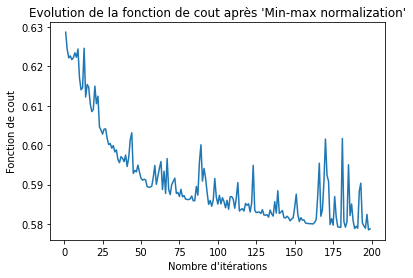

In [17]:
#Min-max normalization
Niter=200
alpha=0.01
cout=np.zeros(Niter-1)
theta=Theta
for j in range (1,Niter):
    MB=randint(0,n_app-30,1)[0]
    theta=theta-(alpha*grad(theta,XappMinMax[MB:(MB+30),:],yapp[MB:(MB+30)],30))
    cout[j-1]=fonctionCout(theta,XappMinMax,yapp,n_app)
absplot=np.linspace(1,Niter-1,Niter-1)
plt.plot(absplot,cout)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de cout")
plt.title("Evolution de la fonction de cout après 'Min-max normalization'")

In [ ]:
#Mean normalization
Niter=200
alpha=0.01
cout=np.zeros(Niter-1)
theta=Theta
for j in range (1,Niter):
    MB=randint(0,n_app-30,1)[0]
    theta=theta-(alpha*grad(theta,XappMean[MB:(MB+30),:],yapp[MB:(MB+30)],30))
    cout[j-1]=fonctionCout(theta,XappMean,yapp,n_app)
absplot=np.linspace(1,Niter-1,Niter-1)
plt.plot(absplot,cout)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de cout")
plt.title("Evolution de la fonction de cout après 'Mean normalization'")

In [ ]:
#Standardization 
Niter=200
alpha=0.01
cout=np.zeros(Niter-1)
theta=Theta
for j in range (1,Niter):
    MB=randint(0,n_app-30,1)[0]
    theta=theta-(alpha*grad(theta,XappStand[MB:(MB+30),:],yapp[MB:(MB+30)],30))
    cout[j-1]=fonctionCout(theta,XappStand,yapp,n_app)
absplot=np.linspace(1,Niter-1,Niter-1)
plt.plot(absplot,cout)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de cout")
plt.title("Evolution de la fonction de cout après 'Standardization'")

On Conservera donc pour la suite la technique de "Standardization" :

In [289]:
Xapp=XappStand
for i in liste_colonne:
    Xtest[:,i]=(Xtest[:,i]-numpy.mean(Xtest, 0)[i])/(numpy.std(Xtest, 0)[i])

## 3.2.2 Recherche Linéaire

Commençons avec la descente à pas optimal avec la méthode de Broyden Fletcher Goldfard Shanno (seule méthode que nous n'avons pas codée à la main dans cette partie Regression Logistique, avec la validation croisée, afin d'avoir accès à des fonctions optimisées qui ne mettent pas trop de temps à tourner)

In [267]:
from scipy.optimize import minimize
theta_0=Theta
#On selectionne au hasard 1600 observations de notre échantillon d'apprentissage pour eviter que ce bloc de calcul mette
#plus de 10 minutes à tourner
XappBFGS=np.copy(Xapp)
yappBFGS=np.copy(yapp)
data=np.c_[XappBFGS,yappBFGS]
np.random.shuffle(data)
XappBFGS=data[1:1601,0:(data.shape[1]-1)]
yappBFGS=data[1:1601,data.shape[1]-1]
def f(theta):
    return(fonctionCout(theta,XappBFGS,yappBFGS,1600))
    #Afin que la fonction minimize comprenne qu'on cherche à optimiser notre fonction 
    #de cout en fonction de theta.
theta=minimize(f,theta_0,method='BFGS', options={'disp': True,'maxiter':2})
print(theta)
#Récuperons à present notre vecteur de paramètre
theta=theta['x']
#par convention on fixera le seuil à 0.5, calculons alors l'erreur de classification sur l'echantillon de test et d'apprentissage
prediction_app=(dot(Xapp,theta)>=0).astype('int')
prediction_test=(dot(Xtest,theta)>=0).astype('int')
erreur_app=(abs(yapp-prediction_app)).mean()
erreur_test=(abs(ytest-prediction_test)).mean()

C:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


         Current function value: nan
         Iterations: 1
         Function evaluations: 30800
         Gradient evaluations: 112
      fun: nan
 hess_inv: array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])
      jac: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan

In [268]:
print("Erreur de classification sur l'echantillon d'apprentissage de BFGS-Grad pas optimal est :", erreur_app)
print("Erreur de classification sur l'echantillon de test de BFGS-Grad pas optimal est :",erreur_test)

Erreur de classification sur l'echantillon d'apprentissage de BFGS-Grad pas optimal est : 0.33679917899967593
Erreur de classification sur l'echantillon de test de BFGS-Grad pas optimal est : 0.3381401469459371


Comparons maintenant ce résultat à celui qu'on aurait obtenu avec Wolfe-Armijo dans le cadre d'une descente de gradient classique (mini-batch toujours afin d'éviter un temps de calcul par bloc trop important)

Erreur de classification sur l'echantillon d'apprentissage de Wolfe-Armijo est : 0.31493734471210977
Erreur de classification sur l'echantillon de test de de Wolfe-Armijo est : 0.31374054172606647


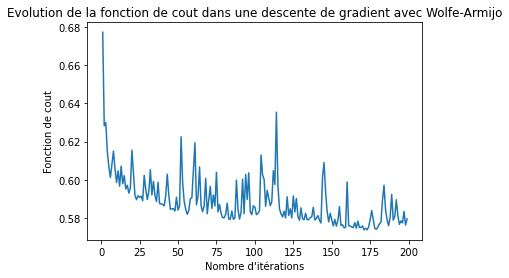

In [273]:
#Par convention on fixera
k=0.8
w=0.9  #on a bien 0<k<w<1
epsilon=1e-4
Niter =200
#on testera différente valeur de alpha suffisament grande pour trouver celle qui verifie à chaque itération Wolfe
alpha_w_possible=[0.001,0.05,0.1,0.5,1,2,5,10,20,50,100,200,500,1000] 
#idem pour Armijo
alpha_a_possible=[0.0001,0.00005,0.00001,0.000005,0.000001,0.0000001,0.00000001]    
def verifie_Wolfe(alpha,theta_n,X,y,n):
    #Retournera True si alpha verifie Wolfe et faux sinon
    #D'après nos resultats théoriques on a que alpha verifie Wolfe si :
    Gradient_J_theta_n=grad(theta_n,X,y,n)
    resultBool=(-np.vdot(Gradient_J_theta_n,grad((theta_n-alpha*Gradient_J_theta_n),X,y,n)) >= w*(-np.vdot(Gradient_J_theta_n,Gradient_J_theta_n)))
    return(resultBool)
def verifie_Armijo(alpha,theta_n,X,y,n):
    #Retournera True si alpha verifie Armijo et faux sinon
    #D'après nos resultats théoriques on a que alpha verifie Armijo si :
    Gradient_J_theta_n=grad(theta_n,X,y,n)
    Phi_en_alpha=fonctionCout(theta_n-(alpha*Gradient_J_theta_n),X,y,n)
    temp=fonctionCout(theta_n,X,y,n)-k*alpha*(np.vdot(Gradient_J_theta_n,Gradient_J_theta_n))
    resultBool=(Phi_en_alpha <= temp)
    return(resultBool)

#Implementons maintenant l'algorithme de dichotomie permettant de trouver notre alpha à chaque itération

def dichotomie(theta_n,alpha_a,alpha_w,X,y,n) :
    temp=0
    while verifie_Wolfe(alpha_w,theta_n,X,y,n)==False:
        assert ( temp<14 ) , "Erreur , alpha_w doit vérifier Wolfe et il ne le vérifie toujours pas pour 1000"
        temp+=1
        alpha_w=alpha_w_possible[temp]
    temp2=0    
    while verifie_Armijo(alpha_a,theta_n,X,y,n)==False:
        assert ( temp2<5 ) , "Erreur , alpha_a doit vérifier Armijo et il ne le vérifie toujours pas pour 0.00000001"
        temp2=temp2+1
        alpha_a=alpha_a_possible[temp2]
    xmoins , xplus , xn = alpha_a , alpha_w , ( alpha_a + alpha_w )/2 
    for f in range (Niter) :
        if  verifie_Armijo(xplus-epsilon,theta_n,X,y,n): 
            return(xplus)
        if verifie_Armijo(xn,theta_n,X,y,n):
            xmoins = xn 
            xn=(xmoins+xplus)/2
        else :
            xplus = xn
            xn = (xmoins+xplus)/2
    print (" Erreur , Wolfe-Armijo n’a pas trouvé de alpha après ", Niter , " itérations.")

#Nous sommes maintenant en mesure d'implementer notre descente de gradient :
cout=np.zeros(Niter-1)
theta=Theta  
for j in range (1,Niter):
    MB=randint(0,n_app-30,1)[0]
    alpha=dichotomie(theta,alpha_a_possible[0],alpha_w_possible[0],Xapp[MB:(MB+30),:],yapp[MB:(MB+30)],30) 
    #Selection de notre taux d'apprentissage avec Wolfe-Armijo
    theta=theta-(alpha*grad(theta,Xapp[MB:(MB+30),:],yapp[MB:(MB+30)],30))
    cout[j-1]=fonctionCout(theta,Xapp,yapp,n_app)
absplot=np.linspace(1,Niter-1,Niter-1)
plt.plot(absplot,cout)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de cout")
plt.title("Evolution de la fonction de cout dans une descente de gradient avec Wolfe-Armijo")
#par convention on fixera le seuil à 0.5, calculons alors l'erreur de classification sur l'echantillon de test et d'apprentissage
prediction_app=(dot(Xapp,theta)>=0).astype('int')
prediction_test=(dot(Xtest,theta)>=0).astype('int')
erreur_app=(abs(yapp-prediction_app)).mean()
erreur_test=(abs(ytest-prediction_test)).mean()
print("Erreur de classification sur l'echantillon d'apprentissage de Wolfe-Armijo est :", erreur_app)
print("Erreur de classification sur l'echantillon de test de de Wolfe-Armijo est :",erreur_test)


On conclut que "BFGS-Gradient pas optimal" est moins performant que Wolfe-Armijo avec direction de descente classique pour une durée d'apprentissage équivalente assez petite (moins de 10 minutes). En revanche en augmentant le nombre d'itération dans le bloc Wolfe-Armijo et le nombre d'observations tirées au hasard dans notre echantillon d'apprentissage on se rend compte que cet écart se réduit.

On conservera donc Wolfe-Armijo dans la suite pour son efficacité et ses bons résultats.

## 3.2.4 Sur-apprentissage et choix des variables explicatives

In [292]:
#On commence par ajouter toutes les variables au carré :
Xapp2=np.copy(Xapp)
Xtest2=np.copy(Xtest)
Xapp2=np.c_[Xapp2,Xapp2[:,1:m]**2] #On a naturellement pas ajouter l'intercept au carré
Xtest2=np.c_[Xtest2,Xtest2[:,1:m]**2]
m2=Xapp2.shape[1]
#On applique de nouveau Wolfe-Armijo :
Niter = 200
cout=np.zeros(Niter-1)
theta=np.concatenate(((Theta*(sqrt(m)))/(sqrt(m2)),np.random.uniform(-1,1,m-1)/(sqrt(m2))))
for j in range (1,Niter):
    MB=randint(0,n_app-30,1)[0]
    alpha=dichotomie(theta,alpha_a_possible[0],alpha_w_possible[0],Xapp2[MB:(MB+30),:],yapp[MB:(MB+30)],30) 
    #Selection de notre taux d'apprentissage avec Wolfe-Armijo
    theta=theta-(alpha*grad(theta,Xapp2[MB:(MB+30),:],yapp[MB:(MB+30)],30))
    cout[j-1]=fonctionCout(theta,Xapp2,yapp,n_app)
absplot=np.linspace(1,Niter-1,Niter-1)
plt.plot(absplot,cout)
plt.xlabel("Nombre d'itérations")
plt.ylabel("Fonction de cout")
plt.title("Evolution de la fonction de cout dans une descente de gradient avec Wolfe-Armijo")
#par convention on fixera le seuil à 0.5, calculons alors l'erreur de classification sur l'echantillon de test et d'apprentissage
prediction_app2=(dot(Xapp2,theta)>=0).astype('int')
prediction_test2=(dot(Xtest2,theta)>=0).astype('int')
erreur_app2=(abs(yapp-prediction_app2)).mean()
erreur_test2=(abs(ytest-prediction_test2)).mean()
print("Erreur de classification sur l'echantillon d'apprentissage de Wolfe-Armijo est :", erreur_app2)
print("Erreur de classification sur l'echantillon de test de de Wolfe-Armijo est :",erreur_test2)

C:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


AssertionError: Erreur , alpha_a doit vérifier Armijo et il ne le vérifie toujours pas pour 0.00000001

Redéfinition de la fonction de coût et de son gradient

In [359]:
def fonctionCoutRidge(theta,X,y,n,Lambda):
    cout=0
    for i in range (0,n):
        cout=cout+(y[i]*log(sigmoid(np.vdot(X[i,:],theta)))+(1-y[i])*log(1-sigmoid(np.vdot(X[i,:],theta)))) 
        #vdot est le produit scalaire
    return((-(1/n)*cout)+(Lambda/(2*m))*(np.sum(theta**2)))
def gradRidge(theta,X,y,n,Lambda):
    vecteurGrad=np.zeros(m)
    for j in range (0,m):
        temp=0
        for i in range (0,n):
            temp=temp+X[i,j]*(sigmoid(np.vdot(X[i,:],theta))-y[i])
        vecteurGrad[j]=(1/n)*temp
    terme_penalisation=(Lambda/m)*theta
    terme_penalisation[0]=0 #Toujours car on ne pénalise pas l'intercept
    return(vecteurGrad+terme_penalisation)

Nous allons maintenant pouvoir passer à la validation croisée V-fold

lambda_opt :  0.5214008287999684


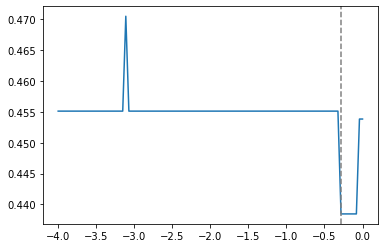

In [360]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
grilleLambda=np.logspace(0,4,100)
grid_score = np.zeros(len(grilleLambda))
LogReg=LogisticRegressionCV(cv=5,Cs = grilleLambda, penalty = 'l2',max_iter=1000)
LogReg.fit(Xapp2,yapp)
grid_score = LogReg.scores_[1].mean(axis=0)
grid_l = 1/grilleLambda[::-1]                              #car la librairie prend en compte 1/lambda 
grid_score = grid_score[::-1]
idx_l_opt = np.argmax(grid_score)
lambda_opt = grid_l[idx_l_opt]
print('lambda_optimal : ', lambda_opt)
#Et on obtient notre lambda optimal par validation croisée V-fold avec V=5 : lambda=0.52

Modèle final :

In [362]:
theta_0=np.ones(m)/5000
def f(theta):
    return(fonctionCoutRidge(theta,Xapp2,yapp,n_app,0.52))
theta=minimize(f,theta_0,method='BFGS', options={'disp': True})
theta=theta['x']
#par convention on fixera le seuil à 0.5, calculons alors l'erreur de classification sur l'echantillon de test et d'apprentissage
prediction_app=(dot(Xapp2,theta)>=0).astype('int')
prediction_test=(dot(Xtest2,theta)>=0).astype('int')
erreur_app=(abs(yapp-prediction_app)).mean()
erreur_test=(abs(ytest-prediction_test)).mean()
print(erreur_app,erreur_test)
#Et nous avons diminuer l'erreur de 0.05 avec l'ajout de variable + pénalisation Ridge

C:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
C:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


         Current function value: nan
         Iterations: 1
         Function evaluations: 44576
         Gradient evaluations: 112
0.31746031746031744 0.3


C:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\Utilisateur\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
